# 2.0 Training models with Anvil
<div style="text-align: center">
<img src="./anvil_diagram.png" alt="Anvil diagram" width="500"/>  
</div>

### Background

Once a dataset has been properly curated, cleaned, and standardized (as described in Section 1.0), the next step is to use that dataset to train predictive models. This is where Anvil, our internal infrastructure for machine learning model training and evaluation, comes into play. Anvil is built to support scalable, reproducible, and rigorous development of ADMET prediction models. Recognizing that building the best models requires training many variants, ensuring their reproducibility, and enabling robust performance comparisons, Anvil centers around a YAML-based recipe system. These recipes allow users to specify model architectures and training procedures in a standardized, shareable format—minimizing code duplication while supporting both deep learning and traditional machine learning approaches.  

Designed with both internal and external engagement in mind, Anvil aims to lower the barrier for outside users to adopt and fine-tune models by offering simple, transparent workflows. Long-term, it will serve as a foundation for broader community involvement and model reuse. Importantly anvil allows **systematic rigorous experimentation** with easy training and comparison between different model strategies.

### Requirements
To run Anvil, you need:
1. A dataset that has been processed with `01_Curate_Data_ChEMBL.ipynb`.  
2. A `YAML` file with instructions for Anvil. We will show you how to create this file in this notebook.

# Overview

This notebook will walk you through how to run a series of Anvil model training workflows with the CYP3A4 Inhibition data we curated from ChEMBL in our previous notebook `01_Curate_Data_ChEMBL.ipynb`


## Creating an anvil workflow
At the heart of every Anvil run is a set of workflow steps captured in a YAML configuration file. This file describes the entire model training pipeline in a structured, declarative format. It allows you to specify:

* Data loading: What dataset to use and how to locate it.
* Data preprocessing: Filtering, transformations, label normalization, etc.
* Splitting strategy: Train/validation/test splitting method (e.g., scaffold-based, random, temporal).
* Featurization: How molecular structures should be represented (e.g., fingerprints, learned embeddings, descriptors).
* Model architecture: Whether to use tree-based methods, fully connected neural nets, graph neural networks, etc.
* Training parameters: Optimizer settings, learning rates, batch sizes, early stopping criteria.
* Evaluation settings: What metrics to compute (e.g., ROC-AUC, RMSE, R²) and what plots to generate.


Fundamentally the YAML file maps each workflow step to schema in the [OpenADMET Models codebase](https://github.com/OpenADMET/openadmet-models). This means you can create the workflow directly from code or work directly from a YAML file.



## 2.1 Training a series of models

This quickstart will walkthrough two anvil setups and the corresponding YAML files `YAML` files: one for training a traditional machine learning model (`anvil_lgbm.yaml`) and one for training a deep learning model (`anvil_chemprop.yaml`).


## 2.2 Anvil deep dive

We will examine a typical set of sections in anvil workflow from a **code perspective**, see how to construct a worflow from components, how they map to code. See the [other notebook](./02.2_Anvil_deep_dive.ipynb) in this directory


> **_NOTE:_**  See the [Anvil reference guide](https://openadmet-models.readthedocs.io/en/latest/anvil_reference.html) and other sections of our documentation for more information 


# 2.1 Training a series of models

**We are going to go directly into training our CYP3A4 inhibiton model from a YAML file.** As detailed Anvil is designed to provide a high level interface to training and evaluating models and should be easy to use out of the box. As a reminder we will be training directly against CYP3A4 pIC50s from ChEMBL. 

For a more detailed view on the inner workings of Anvil see the [other notebook](./02.2_Anvil_deep_dive.ipynb) in this directory.






## Training a traditional machine learning LightGBM 

Here is a `YAML` file for training a LightGBM (LGBM) model.

Be sure to read through the comments (in green) to understand each field.  


At a high level broken down by anvil section:


* **Data loading:** Load from a local CSV file that we previously curated the general 
* **Data preprocessing:** Minimal transformation
* **Splitting strategy:** Split randomly into train and test set at 80:20 ratio 
* **Featurization:** Concatenated ECFP4 fingerprints with RDKit descriptors as input features
* **Model architecture:** LightGBM gradient boosted model, commonly used in low-medium data regimes
* **Training parameters:** Basic scikit-learn trainer, compatible with any 
* **Evaluation settings:** Generate metrics and regression plots and do [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)


See the [Anvil reference guide](https://openadmet-models.readthedocs.io/en/latest/anvil_reference.html) for a full list of all the options available in Anvil


Note here that cross validation is important as it allows us to sample from the performance distribution of our model, rather than just evaluating performance on a single split. 
Here we do 5x5 repeated cross validation (5 folds, 5 repeats). For more information on why cross validation (or more generally, sampling from the performance distribution) is so important see [this article](https://pubs.acs.org/doi/pdf/10.1021/acs.jcim.5c01609?ref=article_openPDF)



```yaml 
# This spection specifies the input data
data:
  # Specify the dataset file
  resource: ../01_Data_Curation/processed_data/processed_CYP3A4_inhibition.csv
  type: intake
  input_col: OPENADMET_CANONICAL_SMILES
  # Specify each (1+) of the target columns, or the column that you're trying to predict
  target_cols:
  - pchembl_value_mean
  # Whether or not to drop rows with no target value
  dropna: true

# Additional metadata
metadata:
  authors: Your Name
  email: youremail@mail.com
  biotargets:
  - CYP3A4
  build_number: 0
  description: basic regression using a LightGBM model
  driver: sklearn
  name: lgbm_pchembl_CYP3A4_prototype
  tag: openadmet-chembl
  tags:
  - openadmet
  - test
  - pchembl
  version: v1

# Section specifying training procedure
procedure:
# Featurization specification
  feat:
    # Using concatenated features, which combines multiple featurizers
    # here we use DescriptorFeaturizer and FingerprintFeaturizer for 2D RDKit descriptors and ECFP4 fingerprints
    # See openadmet.models.features 
    type: FeatureConcatenator
    # Add parameters for the featurizer. Full description of the featurizer options are in Section 5.
    params:
      featurizers:
        DescriptorFeaturizer:
          descr_type: "desc2d"
        FingerprintFeaturizer:
          fp_type: "ecfp:4"
  
  # Model specification
  model:
    # Indicate model type
    # See openadmet.models.architecture for all model types
    type: LGBMRegressorModel
    # Specify model parameters
    params {}


  # Specify data splits
  split:
    # Specify how data will be split
    # See openadmet.models.split
    type: ShuffleSplitter
    # Specify split parameters
    params:
      random_state: 42
      train_size: 0.8
      val_size: 0.0 # For LGBM, no validation set is needed
      test_size: 0.2 # If you want to compare tree-based models with Dl models later, the test sizes should match
    
  # Specify training configuration
  train:
    # Specify the trainer, here SKLearnBasicTrainer as model has an sklearn interface
    # could also use SKLearnGridSearchTrainer for hyperparameter tuning
    type: SKLearnBasicTrainer


# Section specifying report generation
report:
  # Configure evaluation
  eval:
  # Generate regression metrics
  - type: RegressionMetrics
    params: {}
  # Generate regression plots & do cross validation
  - type: SKLearnRepeatedKFoldCrossValidation
    params:
      axes_labels:
      - True pAC50
      - Predicted pAC50
      max_val: 10
      min_val: 3
      pXC50: true
      n_splits: 5
      n_repeats: 5
      title: True vs Predicted pAC50 on test set

```



 ## Running a workflow using the CLI


OpenADMET Models has a convenient CLI that you can use to run `anvil`
After you have created or modified this `YAML` file to your liking, you can run the workflow with the below command either in a `bash` cell or in your command line:
```
openadmet anvil --recipe-path <your_file.yaml> --output-dir <output-directory>
```

This may take 5-10 minutes to run, depending on your processor. Re-running this command will create a different directory with a hash appended if it already exists

In [ ]:
%%bash
export OADMET_NO_RICH_LOGGING=1
openadmet anvil --recipe-path anvil_lgbm.yaml --output-dir lgbm

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


[09/29/25 16:34:40] INFO     Making workflow from           ]8;id=19566;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py\specification.py]8;;\:]8;id=952958;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py#615\615]8;;\
                             specification                                      
Workflow initialized successfully with recipe: anvil_lgbm.yaml
                    INFO     Running workflow from directory     ]8;id=9366;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=426287;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#229\229]8;;\
                             lgbm_2025-09-29_5731fe                             
                    INFO     Running with driver sklearn         ]8;id=66

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 ## Running a workflow using the code interface 

You can also run the same workflow using the code interface. This takes care of translating the YAML file into classes and aranging all of the relvant components

In [2]:
from openadmet.models.anvil.specification import AnvilSpecification

workflow_spec =  AnvilSpecification.from_recipe("anvil_lgbm.yaml")
workflow_spec.model_dump()

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


{'metadata': {'version': 'v1',
  'driver': 'sklearn',
  'name': 'lgbm_pchembl',
  'build_number': 0,
  'description': 'basic regression using a LightGBM model',
  'tag': 'openadmet-chembl',
  'authors': 'Your Name',
  'email': 'youremail@email.com',
  'biotargets': ['PXR'],
  'tags': ['openadmet', 'test', 'pchembl']},
 'data': {'type': 'intake',
  'resource': '../01_Data_Curation/processed_data/processed_CYP3A4_inhibition.csv',
  'cat_entry': None,
  'target_cols': ['OPENADMET_LOGAC50'],
  'input_col': 'OPENADMET_CANONICAL_SMILES',
  'anvil_dir': 'file:///store/projects/OpenADMET/openadmet-toolkit/openadmet-demos/demos/02_Model_Training',
  'dropna': True},
 'procedure': {'split': {'type': 'ShuffleSplitter',
   'params': {'random_state': 42,
    'train_size': 0.8,
    'val_size': 0.0,
    'test_size': 0.2}},
  'feat': {'type': 'FeatureConcatenator',
   'params': {'featurizers': {'DescriptorFeaturizer': {'descr_type': 'desc2d'},
     'FingerprintFeaturizer': {'fp_type': 'ecfp:4'}}}},
  

[09/29/25 14:30:48] INFO     Making workflow from specification                                ]8;id=878;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py\specification.py]8;;\:]8;id=744010;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py#615\615]8;;\

[09/29/25 14:30:49] INFO     Running workflow from directory lgbm_from_code_2025-09-29_2f4ea4       ]8;id=455480;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=296789;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#229\229]8;;\

                    INFO     Running with driver sklearn                                            ]8;id=191351;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=764289;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#232\232]8;;\

                    INFO     Loading data                                                           ]8;id=282123;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=79209;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#235\235]8;;\

                    INFO     4800 total rows. 0 NaN rows were dropped.                         ]8;id=394383;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py\specification.py]8;;\:]8;id=1155;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py#164\164]8;;\

                    INFO     Data loaded                                                            ]8;id=636137;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=631476;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#237\237]8;;\

                    INFO     Splitting data                                                         ]8;id=599640;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=525556;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#240\240]8;;\

                    INFO     Data split                                                             ]8;id=857039;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=112381;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#256\256]8;;\

                    INFO     Featurizing data                                                       ]8;id=537922;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=9352;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#259\259]8;;\

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[09/29/25 14:31:13] INFO     No transform specified, skipping                                       ]8;id=5480;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=577903;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#290\290]8;;\

                    INFO     Data featurized                                                        ]8;id=839619;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=885928;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#292\292]8;;\

                    INFO     Building model                                                          ]8;id=23929;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=712413;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#98\98]8;;\

                    INFO     Model built                                                            ]8;id=903902;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=491736;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#100\100]8;;\

                    INFO     Setting model in trainer                                               ]8;id=21763;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=314607;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#103\103]8;;\

                    INFO     Model set in trainer                                                   ]8;id=409456;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=747045;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#105\105]8;;\

                    INFO     Training model                                                         ]8;id=45014;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=816142;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#108\108]8;;\

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27079
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 1842
[LightGBM] [Info] Start training from score 5.442520


                    INFO     Model trained                                                          ]8;id=646335;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=56643;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#110\110]8;;\

                    INFO     Saving model                                                           ]8;id=710771;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=419912;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#329\329]8;;\

                    INFO     Model saved                                                            ]8;id=803073;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=779065;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#334\334]8;;\

                    INFO     Predicting                                                             ]8;id=715488;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=173698;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#337\337]8;;\

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


                    INFO     Predictions made                                                       ]8;id=599385;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=272506;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#350\350]8;;\

                    INFO     Evaluating                                                             ]8;id=170259;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=747329;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#353\353]8;;\

[09/29/25 14:31:21] INFO     Starting cross-validation                                      ]8;id=330404;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py\cross_validation.py]8;;\:]8;id=756303;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py#178\178]8;;\

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26559
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1696
[LightGBM] [Info] Start training from score 5.438173


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26505
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1684
[LightGBM] [Info] Start training from score 5.441539


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26562
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1697
[LightGBM] [Info] Start training from score 5.446781


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26562
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1691
[LightGBM] [Info] Start training from score 5.453149


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26529
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1684
[LightGBM] [Info] Start training from score 5.432960


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26554
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1698
[LightGBM] [Info] Start training from score 5.444234


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26547
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1690
[LightGBM] [Info] Start training from score 5.449986


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26538
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1682
[LightGBM] [Info] Start training from score 5.429273


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26517
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1686
[LightGBM] [Info] Start training from score 5.446588


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26571
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1692
[LightGBM] [Info] Start training from score 5.442520


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26549
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1698
[LightGBM] [Info] Start training from score 5.437790


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26556
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1694
[LightGBM] [Info] Start training from score 5.438213


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26520
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1683
[LightGBM] [Info] Start training from score 5.442207


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26577
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1688
[LightGBM] [Info] Start training from score 5.456820


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26536
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1694
[LightGBM] [Info] Start training from score 5.437571


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1693
[LightGBM] [Info] Start training from score 5.443045


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26536
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1694
[LightGBM] [Info] Start training from score 5.437575


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26524
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1696
[LightGBM] [Info] Start training from score 5.446353


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26557
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1689
[LightGBM] [Info] Start training from score 5.440483


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26556
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1690
[LightGBM] [Info] Start training from score 5.445146


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26564
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1698
[LightGBM] [Info] Start training from score 5.429687


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26547
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1693
[LightGBM] [Info] Start training from score 5.437948


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26555
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1699
[LightGBM] [Info] Start training from score 5.443724


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26545
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1690
[LightGBM] [Info] Start training from score 5.451586


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26539
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1686
[LightGBM] [Info] Start training from score 5.449656


/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[09/29/25 14:31:31] INFO     Cross-validation complete                                      ]8;id=288780;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py\cross_validation.py]8;;\:]8;id=985500;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py#204\204]8;;\

[09/29/25 14:31:34] INFO     Evaluation done                                                        ]8;id=874186;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=673035;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#370\370]8;;\

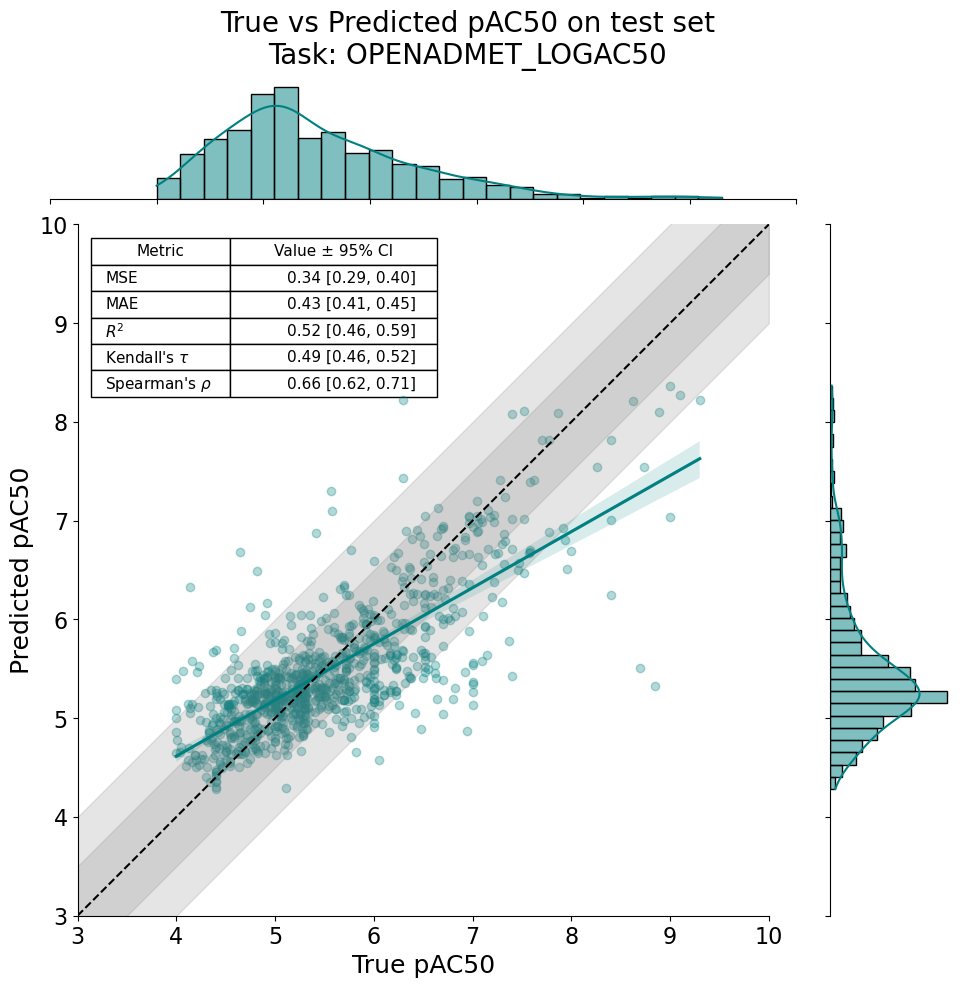

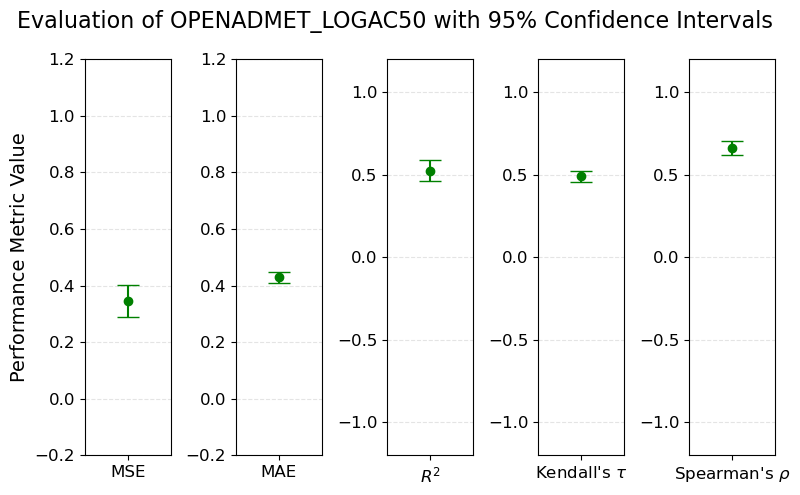

In [3]:
# make a workflow from the specification

workflow = workflow_spec.to_workflow()

# run the workflow 
workflow.run(output_dir="./lgbm_from_code")

## Understanding the output

The outputs of the Anvil workflow are in `/anvil_training`:  
- `/data` folder includes the split data, saved as `.csv` it also contains the featurized splits as Zarr arrays. This is done so that the 
- `/recipe_components` folder contains the inputs from the `2.1_anvil_lgbm.yaml` file split by section
- `cross_validation_metrics.json` is the cross validation metrics of the model saved as a `.json` file
- `model.json` is the model's hyperparameters saved as a `.json` file
- `regression_metrics.json` is the regression metrics saved as a `.json` file
- `model.pkl` is the trained model saved as `.pkl` which can be loaded and used for predictions elsewhere
- `cross_validation_regplot.png` is a plot of the cross validation metrics of the model
- `anvil_recipe.yaml` is a copy of the input `.yaml`



## Interpreting the results

Here is a regression plot showing the performance of our trained LGBM model as trained on a random split of CYP3A4 pIC50 values from ChEMBL. We can see some success with predicting across the activity range available, however there are some significant outliers, in particular, some compounds labelled as very active in the ChEMBL that the model is marking as having medium-low activity (bottom right corner). Overall our performance here is encouraging with modest MAE and MSE, alongside a Kendall's Tau of ~ 0.5, showing some ability to rank order compounds by affinity. Not too shabby for our first try!

<img src="lgbm/cross_validation_regplot.png" alt="LGBM model results" width="500"/>


Lets also take a look at the format we use to report our metrics and metric distributions. We report our metrics as a dictionary with the task name as the primary key. the This is important for when we do multi-task models which can have multiple tasks per training run. We will look at our cross validation results here, which has a metric entry for every split and repeat.  As we did 5x5 cross validation (5 folds, 5 repeats) there will be 25 entries for each metric

In [23]:
import json
with open("./lgbm/cross_validation_metrics.json", 'r') as f:
    cross_val_metrics =  json.load(f)

# cross_val_metrics

In [19]:
mse = cross_val_metrics["OPENADMET_LOGAC50"]["mse"]
mse

{'value': [0.3479656509603264,
  0.3299416156526907,
  0.3603077759139521,
  0.3041070650556461,
  0.3630265489021384,
  0.3300111017009924,
  0.32665756469929574,
  0.388789379804619,
  0.33727357460413065,
  0.3534176369745164,
  0.33732964342541555,
  0.39191521048381145,
  0.34382275371709087,
  0.34747184609482556,
  0.32449746796255047,
  0.3181111508311542,
  0.41448694577798845,
  0.33162833828780014,
  0.3665187664735144,
  0.3010406286874374,
  0.36620663695978656,
  0.3437143402628169,
  0.35534601320243436,
  0.29408226753022043,
  0.3457219732629131],
 'mean': 0.3449356758891227,
 'lower_ci': 0.2897293342452841,
 'upper_ci': 0.40014201753296136,
 'confidence_level': 0.95}

In [25]:
len(mse["value"])

25

In [21]:
kendall_tau = cross_val_metrics["OPENADMET_LOGAC50"]["ktau"]
kendall_tau

{'value': [0.4840859893150339,
  0.48358150960538726,
  0.494519299504423,
  0.5008658777775495,
  0.5056581925088554,
  0.45138985615129784,
  0.4742194947987856,
  0.5328726830719313,
  0.4793589111845179,
  0.5120348114465246,
  0.47691333128763136,
  0.491506006248741,
  0.4909946206233179,
  0.4592244852777877,
  0.519647651553007,
  0.48386123724649066,
  0.48723974615696464,
  0.4910628731097022,
  0.4814685699869738,
  0.49358340353262514,
  0.49633123855619204,
  0.48255261777043046,
  0.4700397326013319,
  0.4993822294121589,
  0.49428620536030415],
 'mean': 0.4894672229635185,
 'lower_ci': 0.45513893748916506,
 'upper_ci': 0.523795508437872,
 'confidence_level': 0.95}


### Next steps 

Ok fantastic! We have trained our LGBM model, but didn't we say that one of the advantages of `anvil` was our ability to train lots of different models? 

Lets go ahead and train a **ChemProp** model next

## Training a ChemProp model

We are able to train a chemprop model using the same system! Lets have a look through the 



```yaml
# This spection specifies the input data
data:
  # Specify the dataset file
  resource: .../01_Data_Curation/processed_data/processed_CYP3A4_inhibition.csv
  type: intake
  input_col: OPENADMET_CANONICAL_SMILES
  # Specify each (1+) of the target columns, or the column that you're trying to predict
  target_cols:
  - OPENADMET_LOGAC50


# Additional metadata
metadata:
  authors: Your Name
  email: youremail@mail.com
  biotargets:
  - CYP3A4
  build_number: 0
  description: basic regression using a ChemProp multitask task model
  driver: pytorch
  name: chemprop_pchembl
  tag: chemprop-CYP3A4-chembl
  tags:
  - openadmet
  - test
  version: v1

# Section specifying training procedure
procedure:
  # Featurization specification
  feat:
    # Using the ChemPropFeaturizer (for ChemProp model)
    # See openadmet.models.features
    type: ChemPropFeaturizer
    # No parameters passed
    params: {}
  
  # Model specification
  model:
    # Indicate model type
    # See openadmet.models.architecture
    type: ChemPropModel
    # Specify model parameters
    params:
      depth: 4
      ffn_hidden_dim: 1024
      ffn_hidden_num_layers: 4
      message_hidden_dim: 2048
      dropout: 0.2
      batch_norm: True
      messages: bond
      n_tasks: 1 # Number of tasks should match the number of target columns
      from_chemeleon: False

  # Specify data splits
  split:
    # Specify how data will be split
    # See openadmet.models.split
    type: ShuffleSplitter
    # Specify split parameters
    params:
      random_state: 42
      train_size: 0.7
      val_size: 0.1
      test_size: 0.2
    
  # Specify training configuration
  train:
    # Specify the trainer, here LightningTrainer as ChemProp is a PyTorch Lightning model
    # See openadmet.models.trainer
    type: LightningTrainer
    # Specify model parameters
    params:
      accelerator: gpu
      early_stopping: true
      early_stopping_patience: 10
      early_stopping_mode: min
      early_stopping_min_delta: 0.001
      max_epochs: 50
      monitor_metric: val_loss
      use_wandb: false
      wandb_project: demos # Specify wandb project name according to guidelines

# Section specifying report generation
report:
  # Configure evaluation
  eval:
  # Generate regression metrics
  - type: RegressionMetrics
    params: {}
  # Generate regression plots & do cross validation
  - type: PytorchLightningRepeatedKFoldCrossValidation
    params:
      axes_labels:
      - True LogAC50
      - Predicted LogAC50
      n_repeats: 5
      n_splits: 5
      random_state: 42
      pXC50: true
      title: True vs Predicted LogAC50 on test set
```

In [1]:
%%bash
# use the CLI
export OADMET_NO_RICH_LOGGING=1
openadmet anvil --recipe-path anvil_chemprop.yaml --output-dir chemprop

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


[09/29/25 16:28:35] INFO     Making workflow from           ]8;id=261966;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py\specification.py]8;;\:]8;id=535371;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py#615\615]8;;\
                             specification                                      
Workflow initialized successfully with recipe: anvil_chemprop.yaml
                    INFO     Running workflow from directory     ]8;id=49;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=370224;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#617\617]8;;\
                             chemprop                                           
                    INFO     Running with driver pytorch         ]8;id

Traceback (most recent call last):
  File "/home/hmacdope/mambaforge/envs/demos3/bin/openadmet", line 7, in <module>
    sys.exit(cli())
             ^^^^^
  File "/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/click/core.py", line 1462, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/click/core.py", line 1383, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/click/core.py", line 1850, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/click/core.py", line 1246, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hmacdope/mambaforge/envs/demos3/l

CalledProcessError: Command 'b'# use the CLI\nexport OADMET_NO_RICH_LOGGING=1\nopenadmet anvil --recipe-path anvil_chemprop.yaml --output-dir chemprop\n'' returned non-zero exit status 1.


# Training a multitask deep learning model


Similarly, we are able to train a multitask deep learning model with the combined data from `1.1_Curating_external_datasets.ipynb`. There are a few changes made to the anvil recipe `anvil_multitask.yaml`: 

We are going to use a multitask matrix we prepared seperately from CYP3A4 data, 

```yaml
# Section specifying input data
data:
  # Specify the dataset file, can be S3 path etc.
  resource:  ./additional_data/multitask.parquet
  # must be intake
  type: intake
  # Specify input column containing SMILES
  input_col: OPENADMET_CANONICAL_SMILES
  # Specify whether or not to drop NaN data rows
  dropna: False
  # Specify each (1+) of the target columns
  target_cols:
  - OPENADMET_LOGAC50_CYP3A4
  - OPENADMET_LOGAC50_PXR
  - OPENADMET_LOGAC50_AHR

# Additional metadata
metadata:
  authors: Your Name
  email: youremail@mail.com
  biotargets:
  - CYP3A4
  - PXR
  - AHR
  build_number: 0
  description: basic regression using a ChemProp multitask task model
  driver: pytorch
  name: chemprop_pchembl
  tag: chemprop
  tags:
  - openadmet
  - test
  - chemprop
  version: v1

# Section specifying training procedure
procedure:
  # Featurization specification
  feat:
    # Using the ChemPropFeaturizer (for ChemProp model)
    # See openadmet.models.features
    type: ChemPropFeaturizer
    # No parameters passed
    params: {}
  
  # Model specification
  model:
    # Indicate model type
    # See openadmet.models.architecture
    type: ChemPropModel
    # Specify model parameters
    params:
      depth: 4
      ffn_hidden_dim: 1024
      ffn_hidden_num_layers: 4
      message_hidden_dim: 2048
      dropout: 0.2
      batch_norm: True
      messages: bond
      n_tasks: 3 # Number of tasks should match the number of target columns
      from_chemeleon: False

  # Specify data splits
  split:
    # Specify how data will be split, can be ShuffleSplitter, ScaffoldSplitter, etc.
    # See openadmet.models.split
    type: ShuffleSplitter
    # Specify split parameters
    params:
      random_state: 42
      train_size: 0.7
      val_size: 0.1
      test_size: 0.2
    
  # Specify training configuration
  train:
    # Specify the trainer, here LightningTrainer as ChemProp is a PyTorch Lightning model
    # See openadmet.models.trainer
    type: LightningTrainer
    # Specify model parameters
    params:
      accelerator: gpu
      early_stopping: true
      early_stopping_patience: 10
      early_stopping_mode: min
      early_stopping_min_delta: 0.001
      max_epochs: 50
      monitor_metric: val_loss
      use_wandb: false
      wandb_project: demos # Specify wandb project name according to guidelines

# Section specifying report generation
report:
  # Configure evaluation
  eval:
  # Generate regression metrics
  - type: RegressionMetrics
    params: {}
  # Generate regression plots & do cross validation
  - type: PytorchLightningRepeatedKFoldCrossValidation
    params:
      axes_labels:
      - True LogAC50
      - Predicted LogAC50
      n_repeats: 5
      n_splits: 5
      random_state: 42
      pXC50: true
      title: Multitask True vs Predicted LogAC50 on test set
```




In [ ]:
%%bash
export OADMET_NO_RICH_LOGGING=1
openadmet anvil --recipe-path anvil_chemprop_multitask.yaml --output-dir multitask

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


[09/29/25 16:21:19] INFO     Making workflow from           ]8;id=171988;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py\specification.py]8;;\:]8;id=922901;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/specification.py#615\615]8;;\
                             specification                                      
Workflow initialized successfully with recipe: anvil_chemprop_multitask.yaml
                    INFO     Running workflow from directory     ]8;id=236237;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=789062;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#617\617]8;;\
                             multitask_2025-09-29_227052                        
                    INFO     Running with driver pytorch 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


                    INFO     Trainer prepared                    ]8;id=816096;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=18924;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#447\447]8;;\
                    INFO     Training model                      ]8;id=471246;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=57557;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#450\450]8;;\
                    DEBUG    Training model MPNN(               ]8;id=431191;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/trainer/lightning.py\lightning.py]8;;\:]8;id=161427;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 8.7 M  | train
1 | agg             | NormAggregation    | 0      | train
2 | bn              | BatchNorm1d        | 4.1 K  | train
3 | predictor       | RegressionFFN      | 2.1 M  | train
4 | X_d_transform   | Identity           | 0      | train
5 | metrics         | ModuleList         | 0      | train
--------------------------------------------------------

Epoch 0: 100%|██████████| 92/92 [00:03<00:00, 28.45it/s, v_num=0, train_loss_step=0.773]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 92/92 [00:03<00:00, 27.64it/s, v_num=0, train_loss_step=0.665, val_loss=0.883, train_loss_epoch=0.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 92/92 [00:03<00:00, 27.73it/s, v_num=0, train_loss_step=0.609, val_loss=0.949, train_loss_epoch=0.969]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 92/92 [00:03<00:00, 28.51it/s, v_num=0, train_loss_step=0.583, val_loss=0.785, train_loss_epoch=0.816]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 92/92 [00:03<00:00, 28.85it/s, v_num=0, train_loss_step=0.534, val_loss=0.799, train_loss_epoch=0.758]
Validation: |          | 0/

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[09/29/25 16:23:01] INFO     Predictions made                    ]8;id=559161;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=130808;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#724\724]8;;\
                    INFO     Evaluating                          ]8;id=340520;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py\workflow.py]8;;\:]8;id=714904;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/anvil/workflow.py#727\727]8;;\
[09/29/25 16:23:25] INFO     Starting cross-validation   ]8;id=429387;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py\cross_validation.py]8;;\:]8;id=603740;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/ope

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


[09/29/25 16:23:26] DEBUG    Training model MPNN(               ]8;id=675015;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/trainer/lightning.py\lightning.py]8;;\:]8;id=270362;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/trainer/lightning.py#177\177]8;;\
                               (message_passing):                               
                             BondMessagePassing(                                
                                 (W_i): Linear(in_features=86,                  
                             out_features=2048, bias=False)                     
                                 (W_h):                                         
                             Linear(in_features=2048,                           
                             out_features=2048, bias=False)                     
                                 (W_o):                                         

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 8.7 M  | train
1 | agg             | NormAggregation    | 0      | train
2 | bn              | BatchNorm1d        | 4.1 K  | train
3 | predictor       | RegressionFFN      | 2.1 M  | train
4 | X_d_transform   | Identity           | 0      | train
5 | metrics         | ModuleList         | 0      | train
---------------------------------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.278    Total estimated model params size (MB)
23        Modules in train mode
3         Modules in eval mode
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:527: Found 3 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 74/74 [00:02<00:00, 30.83it/s, v_num=0, train_loss_step=0.794]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 74/74 [00:02<00:00, 28.43it/s, v_num=0, train_loss_step=0.577, val_loss=0.982, train_loss_epoch=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 74/74 [00:02<00:00, 28.63it/s, v_num=0, train_loss_step=0.631, val_loss=1.330, train_loss_epoch=0.947]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 74/74 [00:02<00:00, 28.49it/s, v_num=0, train_loss_step=0.544, val_loss=0.821, train_loss_epoch=0.853]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 74/74 [00:02<00:00, 28.68it/s, v_num=0, train_loss_step=0.500, val_loss=0.781, train_loss_epoch=0.789]
Validation: |          | 0/

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 74/74 [00:04<00:00, 16.71it/s, v_num=0, train_loss_step=0.0523, val_loss=0.625, train_loss_epoch=0.0791]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[09/29/25 16:27:25] INFO     Fold 1                      ]8;id=224849;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py\cross_validation.py]8;;\:]8;id=992895;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py#541\541]8;;\
                    DEBUG    X_train shape: (9410,)      ]8;id=889934;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py\cross_validation.py]8;;\:]8;id=556292;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py#549\549]8;;\
                    DEBUG    y_train shape: (9410, 3)    ]8;id=851525;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/eval/cross_validation.py\cross_validation.py]8;;\:]8;id=709968;file:///home/hmacdope/mambaforge/envs/demos3/lib

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


[09/29/25 16:27:26] DEBUG    Training model MPNN(               ]8;id=315599;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/trainer/lightning.py\lightning.py]8;;\:]8;id=567835;file:///home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/openadmet/models/trainer/lightning.py#177\177]8;;\
                               (message_passing):                               
                             BondMessagePassing(                                
                                 (W_i): Linear(in_features=86,                  
                             out_features=2048, bias=False)                     
                                 (W_h):                                         
                             Linear(in_features=2048,                           
                             out_features=2048, bias=False)                     
                                 (W_o):                                         

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 8.7 M  | train
1 | agg             | NormAggregation    | 0      | train
2 | bn              | BatchNorm1d        | 4.1 K  | train
3 | predictor       | RegressionFFN      | 2.1 M  | train
4 | X_d_transform   | Identity           | 0      | train
5 | metrics         | ModuleList         | 0      | train
---------------------------------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.278    Total estimated model params size (MB)
23        Modules in train mode
3         Modules in eval mode
/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to

/home/hmacdope/mambaforge/envs/demos3/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:527: Found 3 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 74/74 [00:02<00:00, 29.66it/s, v_num=0, train_loss_step=0.687]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 74/74 [00:02<00:00, 27.30it/s, v_num=0, train_loss_step=0.691, val_loss=1.280, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 74/74 [00:03<00:00, 21.10it/s, v_num=0, train_loss_step=0.691, val_loss=1.240, train_loss_epoch=0.950]

We will examine the full results of these models in `3_Evaluation`.

Congrats! You now know how to train models with the Anvil workflow. Explore our [model catalog](https://github.com/OpenADMET/openadmet-models/tree/2f58b521cdf122d8c929f6b64aead96d1378cd6f/openadmet/models) for other model architectures and featurizers.

✨✨✨✨✨✨✨